In [1]:
!wget http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz

--2022-08-09 05:33:19--  http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/preprocessed/enron1.tar.gz
Resolving nlp.cs.aueb.gr (nlp.cs.aueb.gr)... 195.251.248.252
Connecting to nlp.cs.aueb.gr (nlp.cs.aueb.gr)|195.251.248.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1802573 (1.7M) [application/x-gzip]
Saving to: ‘enron1.tar.gz’

enron1.tar.gz       100%[===================>]   1.72M   379KB/s    in 4.6s    

2022-08-09 05:33:25 (379 KB/s) - ‘enron1.tar.gz’ saved [1802573/1802573]



In [3]:
!tar -xf enron1.tar.gz

In [4]:
!pwd

/content


In [5]:
import glob
import os
mails =[]
labels = []

file_path = 'enron1/spam/'

for filename in glob.glob(os.path.join(file_path,"*.txt")) :
  with open(filename,'r',encoding="ISO-8859-1") as infile : 
    mails.append(infile.read())
    labels.append(1)

In [6]:
file_path = 'enron1/ham/'

for filename in glob.glob(os.path.join(file_path,"*.txt")) :
  with open(filename,'r',encoding="ISO-8859-1") as infile : 
    mails.append(infile.read())
    labels.append(0)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mails,labels,test_size=0.33,random_state=0)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv_train = CountVectorizer(stop_words="english",max_features=500)
term_docs_train = cv_train.fit_transform(x_train)
term_docs_test = cv_train.fit_transform(x_test)

In [11]:
term_docs_test[0]

<1x500 sparse matrix of type '<class 'numpy.int64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [12]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=1.0 , fit_prior=True)
clf.fit(term_docs_train,y_train)

MultinomialNB()

In [13]:
prediction = clf.predict(term_docs_test)
prediction

array([0, 1, 1, ..., 0, 1, 1])

In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,prediction,labels=[0,1])

array([[937, 286],
       [169, 315]])

In [16]:
# accuracy
accuracy = clf.score(term_docs_test, y_test)
accuracy

0.7334504979496193

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_test,prediction,pos_label=1))
print(recall_score(y_test,prediction,pos_label=1))
print(f1_score(y_test,prediction,pos_label=1))

0.5241264559068219
0.6508264462809917
0.5806451612903226


In [18]:
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob

array([[1.00000000e+00, 4.33447224e-64],
       [9.34528895e-02, 9.06547110e-01],
       [1.86871745e-06, 9.99998131e-01],
       ...,
       [9.99991218e-01, 8.78177096e-06],
       [1.35446500e-03, 9.98645535e-01],
       [7.00406119e-04, 9.99299594e-01]])

In [19]:
import numpy as np
pos_prob = prediction_prob[:,1]

In [20]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,pos_prob)

0.756548894129731

In [21]:
thresholds = np.arange(0.0,1.2,0.1)

In [22]:
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1])

In [23]:
true_pos , true_neg = [0]*len(thresholds) , [0]*len(thresholds)

In [24]:
for pred, y in zip(pos_prob, y_test) : 
  for i, threshold in enumerate(thresholds) :
    if pred >= threshold and y == 1 :
      true_pos[i] +=1
    elif pred < threshold and y == 0 :
      true_neg[i] +=1

sensitivity = [tp/np.sum(y_test) for tp in true_pos]
cmpl_specificity = [1-tn/(len(y_test)-np.sum(y_test)) for tn in true_neg]

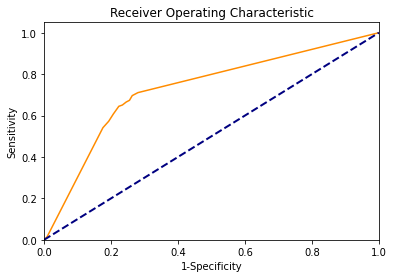

In [25]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(cmpl_specificity,sensitivity, color = 'darkorange')
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])

plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic')
plt.show()